In [364]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *
from sfdata import SFScanInfo

import warnings
warnings.filterwarnings('ignore')


In [366]:
pgroup = 'p20572'
Loaddir_name = 'Reduced_XANES'

#runlist = np.arange(22, 23)
runlist = [136,160]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Camila/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

data = {}
globals().update(data)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print (runlist)
print ('{} scan(s), {} steps each'.format(len(runlist), int(len(DataDiode1_pump)/len(runlist))))

[136, 160]
2 scan(s), 49 steps each


# ONE diode: 
* [Plot averaged curves](#Ave_data)
* [Overlay different scans](#Overlay)

# TWO diodes:
* [Plot averaged curves](#Ave_data_2)
* [Overlay different scans](#Overlay2)
* [Average the 2 diodes](#average_2diodes)

<a id='Ave_data'></a>
## Average scans 1 diode

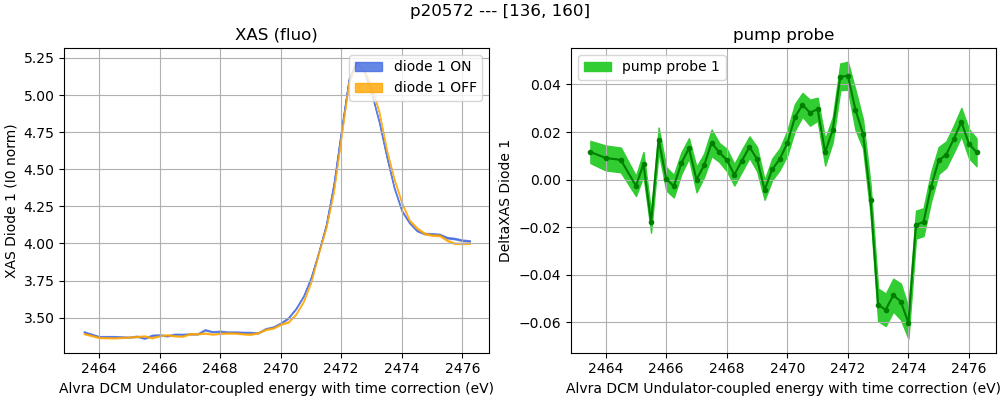

In [367]:
Energy_eV, DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, goodshots1 = \
Plot_AveScans_1diode(titlestring_stack, scan, data, len(runlist), timescan=False)

## save the averaged spectra to load them overlaid

In [368]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='/das/work/p20/p20572/Camila/Reduced_XANES/Averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

def average_array(array, axis):
    return np.mean(array, axis=axis)
save_reduced_data_1diode(reducedir, run_name, scan, 
                         average_array(DataDiode1_pump, 0), 
                         average_array(DataDiode1_unpump, 0), 
                         average_array(Pump_probe_Diode1, 0), 
                         average_array(goodshots1, 0),
                         average_array(correlation1, 0))
print (reducedir+run_name)

/das/work/p20/p20572/Camila/Reduced_XANES/Averaged/run0136-Fe3_CytC_XAS_5000fs_1.1uJ


In [249]:
np.shape(Pump_probe_Diode1)
pp_100ns = np.average(Pump_probe_Diode1, axis=0)

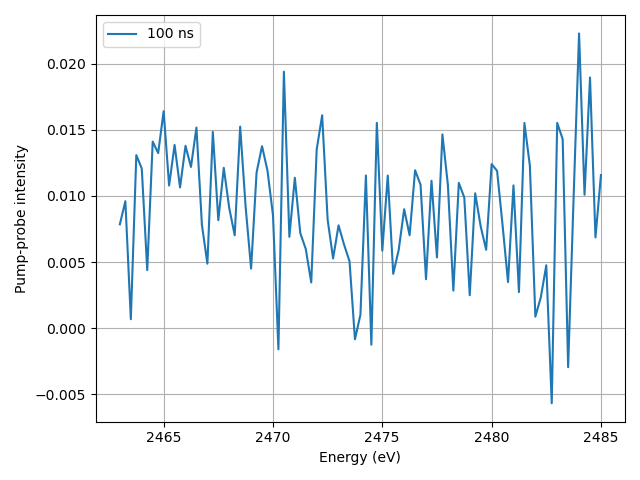

In [250]:
fig, ax = plt.subplots()

# ax.plot(Energy_eV, pp_250fs[:,0], label='250 fs')
# ax.plot(Energy_eV, pp_3ps[:,0], label='3 ps')
# ax.plot(Energy_eV, pp_25ps[:,0], label='25 ps')
ax.plot(Energy_eV, pp_100ns[:,0], label='100 ns')

# ax.fill_between(Energy_eV, pp_250fs[:,1], pp_250fs[:,2], color='b', alpha=0.3)
# ax.fill_between(Energy_eV, pp_3ps[:,1], pp_3ps[:,2], color='orange', alpha=0.3)
# ax.fill_between(Energy_eV, pp_25ps[:,1], pp_25ps[:,2], color='g', alpha=0.3)
# ax.fill_between(Energy_eV, pp_100ns[:,1], pp_100ns[:,2], color='r', alpha=0.3)

ax.set_title('')
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Pump-probe intensity')

ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

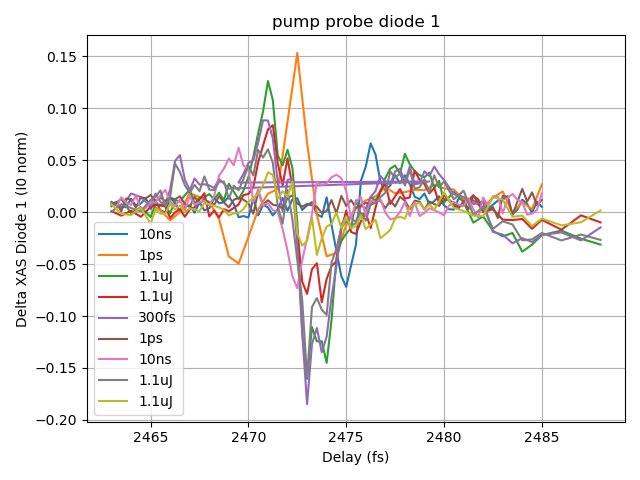

In [169]:
fig, ax1 = plt.subplots(1)

paths = glob.glob(reducedir+'*/run_array.npy')
run_arrays = [np.load(path, allow_pickle=True).item() for path in paths]

for run_array in run_arrays:
    
    for key in run_array.keys():
        delay = run_array[key]['name'].split('_')[-1]
        runnumber = run_array[key]["name"].split('-')[0]
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        Energy_eV = run_array[key]["readbacks"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        #ax1.plot(Energy_eV, D1p[:,0], label=runnumber)
        #ax1.plot(Energy_eV, XAS2_pump_probe[:,0], label=lab[index]+'_'+runnumber)
        # ax3 = plt.twinx(ax1)
        # ax3.plot(Energy_eV, XAS1_pump_probe[:,0], label=runnumber)
        
        ax1.plot(Energy_eV, XAS1_pump_probe[:,0], label=delay)
        
        
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

ax1.set_title('pump probe diode 1')

plt.tight_layout()
plt.show()

<a id='Overlay'></a>
## Overlay different scans 1 diode

In [303]:
pgroup = 'p20572'
#runlist = np.arange(10, 12, 1)
runlist = [137]

Loaddir_folder = 'Reduced_XANES/Averaged'

##############################################
Loaddir = '/sf/alvra/data/{}/work/Camila/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 1 runs: [137] from /sf/alvra/data/p20572/work/Camila/Reduced_XANES/Averaged/


['/sf/alvra/data/p20572/work/Camila/Reduced_XANES/Averaged/run0137-Fe3_CytC_XAS_15000fs_1.1uJ/run_array.npy']

IndexError: list index out of range

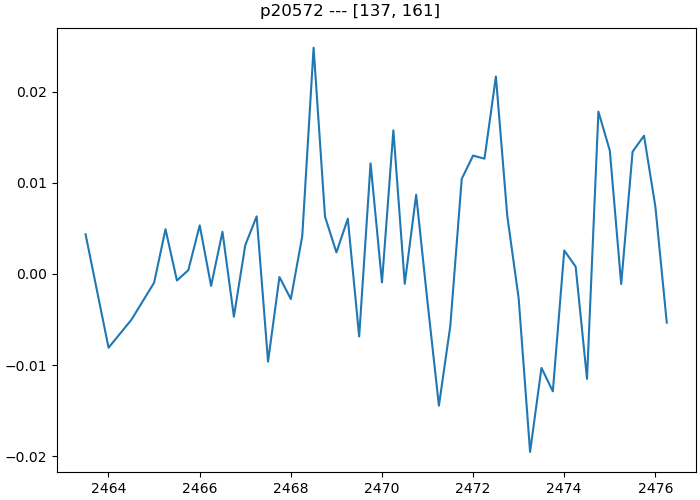

In [294]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)
if 'averaged' in Loaddir:
    plt.suptitle(titlestring_stack + ' averaged')

keys = []
#lab = ['50ps','1ps','200fs']
spec = {}
for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        #Energy_eV = run_array[key]["Energy_eV"]
        Energy_eV = run_array[key]["readbacks"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        # ax1.plot(Energy_eV, (D1u[:,0]-np.mean(D1u[:5,0]))/np.max(D1u[:,0]-np.mean(D1u[:5,0])), label=runnumber)
        spec[runnumber] = (D1u[:,0]-np.mean(D1u[:5,0]))/np.max(D1u[:,0]-np.mean(D1u[:5,0]))
        ax1.plot(Energy_eV, XAS1_pump_probe[:,0], label=runnumber) #plot pump probe
        #ax1.axes.errorbar(Energy_eV, D1u[:,0], err1_low_unpump, err1_high_unpump, label=runnumber) #plot laser off

        # ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], (err1_low_pump_probe, err1_high_pump_probe), label=runnumber)
        #ax2 = plt.twinx(ax1)
        #ax2.plot(Energy_eV, D1p[:,0], label=runnumber)
        
# ax1.plot(Energy_eV, spec['run0041']-spec['run0071'])       
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
#ax1.set_xlim(-1000, 50000)
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2466.35,2466.75, 2469.55, 2472], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('pump probe')
plt.show()

<a id='Ave_data_2'></a>
## Average scans 2 diodes

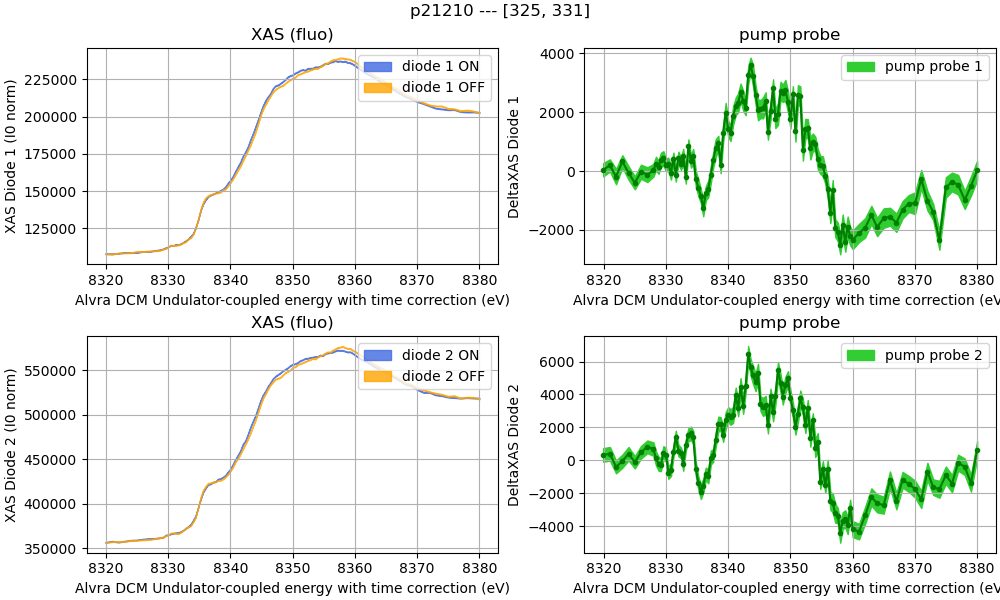

In [13]:
Energy_eV, DataDiode1_pump, DataDiode2_pump, DataDiode1_unpump, DataDiode2_unpump, Pump_probe_Diode1, Pump_probe_Diode2, goodshots1, goodshots2 = \
Plot_AveScans_2diodes(titlestring_stack, scan, data, len(runlist), timescan=False)

## save the averaged spectra to load them overlaid

In [83]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_XANES_test/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

def average_array(array, axis):
    return np.mean(array, axis=axis)
save_reduced_data_2diodes(reducedir, run_name, scan, 
                          average_array(DataDiode1_pump, 0), 
                          average_array(DataDiode1_unpump, 0), 
                          average_array(Pump_probe_Diode1, 0), 
                          average_array(goodshots1, 0), 
                          average_array(correlation1, 0),
                          average_array(DataDiode2_pump, 0), 
                          average_array(DataDiode2_unpump, 0), 
                          average_array(Pump_probe_Diode2, 0), 
                          average_array(goodshots2, 0),
                          average_array(correlation2, 0))
print (reducedir+run_name)

NameError: name 'DataDiode2_pump' is not defined

<a id='Overlay2'></a>
## Overlay different scans 2 diodes

In [15]:
pgroup = 'p21210'
#runlist = np.arange(10, 12, 1)
runlist = [325, 331]
Loaddir_folder = 'Reduced_XANES_test'

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 2 runs: [325, 331] from /sf/alvra/data/p21210/work/Claudio/Reduced_XANES_test/


['/sf/alvra/data/p21210/work/Claudio/Reduced_XANES_test/run0325-XANES_CuNi_Ni_400nm_200fs/run_array.npy',
 '/sf/alvra/data/p21210/work/Claudio/Reduced_XANES_test/run0331-XANES_CuNi_Ni_400nm_200fs/run_array.npy']

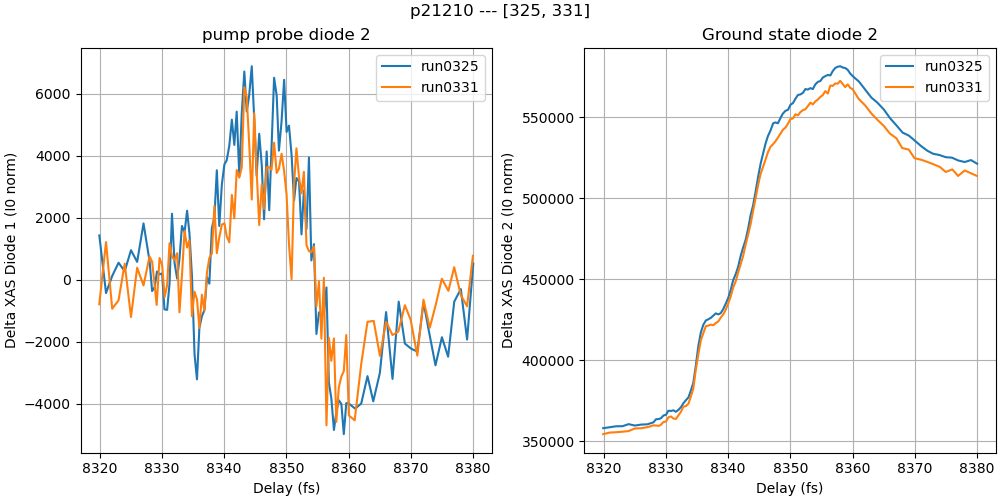

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)
if 'averaged' in Loaddir:
    plt.suptitle(titlestring_stack + ' averaged')

keys = []
#lab = ['400fs','50ps','1ps', '5ps','200fs']

for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        Energy_eV = run_array[key]["readbacks"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        #ax1.plot(Energy_eV, D1p[:,0], label=runnumber)
        #ax1.plot(Energy_eV, XAS2_pump_probe[:,0], label=lab[index]+'_'+runnumber)
        # ax3 = plt.twinx(ax1)
        # ax3.plot(Energy_eV, XAS1_pump_probe[:,0], label=runnumber)
        
        XAS2_pump_probe = run_array[key]["Pump_probe_Diode2"]
        D2p = run_array[key]["DataDiode2_pump"]
        D2u = run_array[key]["DataDiode2_unpump"]
        gs2 = run_array[key]["goodshots2"]

        err2_low_pump    = (D2p[:,0]-D2p[:,1])/np.sqrt(gs2)
        err2_high_pump   = (D2p[:,2]-D2p[:,0])/np.sqrt(gs2)
        err2_low_unpump  = (D2u[:,0]-D2u[:,1])/np.sqrt(gs2)
        err2_high_unpump = (D2u[:,2]-D2u[:,0])/np.sqrt(gs2)

        err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
        err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)
        
        ax1.plot(Energy_eV, XAS2_pump_probe[:,0], label=runnumber)
        
        ax2.plot(Energy_eV, D2u[:,0], label=runnumber)
        #ax2.plot(Energy_eV, XAS2_pump_probe[:,0], label=runnumber)        
        
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()
ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS Diode 2 (I0 norm)")
ax2.legend()
ax2.grid()

ax1.set_title('pump probe diode 2')
ax2.set_title('Ground state diode 2')

plt.show()

<a id='average_2diodes'></a>
## Average the 2 diodes

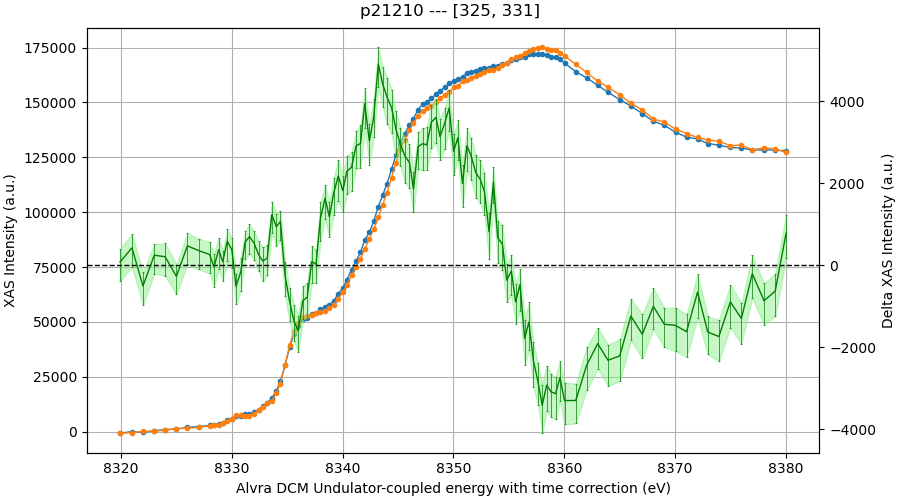

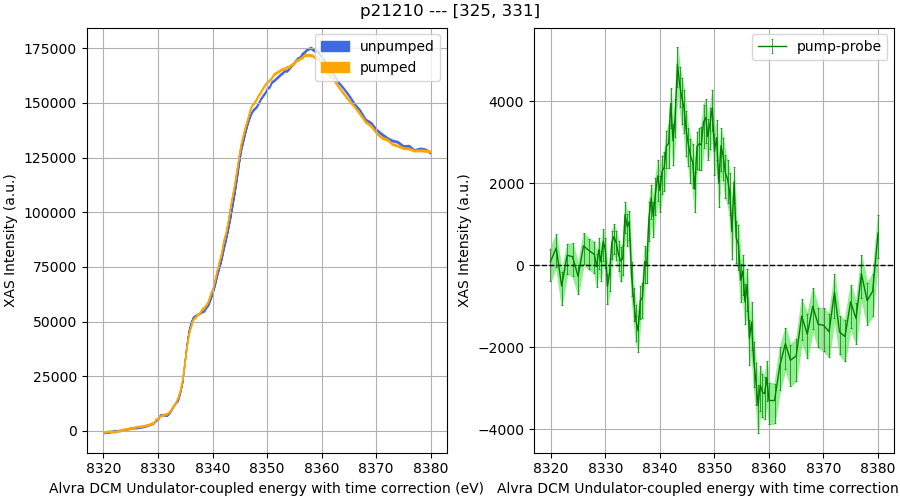

In [17]:
Energy_eV, ave_pp1 = Plot_2diodes_Averaged_2figs(titlestring_stack, scan, data, nscans=2, timescan=False)
Energy_eV, ave_pp1 = Plot_2diodes_Averaged_1fig(titlestring_stack, scan, data, nscans=2, timescan=False)

In [376]:
pgroup = 'p20572'
Loaddir_name = 'Reduced_XANES'

#runlist = np.arange(22, 23)
runlist = [56]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Camila/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

data = {}
globals().update(data)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print (runlist)
print ('{} scan(s), {} steps each'.format(len(runlist), int(len(DataDiode1_pump)/len(runlist))))

[56]
1 scan(s), 78 steps each


### convert npy to mat files

In [377]:
pgroup = 'p20572'
Loaddir_folder = 'Reduced_XANES/Averaged'

Loaddir = '/sf/alvra/data/{}/work/Camila/{}/'.format(pgroup, Loaddir_folder)
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]

import scipy.io
f = glob.glob(Loaddir + '/{}/*.npy*'.format(run_name))[0]

#for file in f:
temp = np.load(f, allow_pickle=True)
mdic = {run_name.split('-')[0]: temp,}
fname = file.split('/')[-1].split('.')[0]
path = (Loaddir + '/Matlab/')
os.makedirs(path, exist_ok=True)
#print (path + '/' + fname)
scipy.io.savemat(path + run_name + '.mat', mdic)

In [378]:
f

'/sf/alvra/data/p20572/work/Camila/Reduced_XANES/Averaged//run0056-Fe2_CytC_XAS_5000fs_1.1uJ/run_array.npy'